## Описание проекта и цели исследования

Нужно разобраться, как ведут себя пользователи мобильного приложения по продаже продуктов питания. У нас есть логи событий за некоторый период. В них хранится информация о действиях пользователей из трех контрольных групп A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, нужно принять решение по результатам A/A/B-теста какой шрифт лучше. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами( группы № 246 и 247) и одну экспериментальную — с новыми(группа № 248). 

В ходе исследования изучим данные, на их основе построим воронку продаж и посмотрим, как пользователи доходят до покупки. Ответим на вопросы: Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

Исследуем результаты A/A/B-эксперимента. Сравним две контрольные группы A/A. Если две контрольные группы окажутся равны, можно быть уверенными в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Проведем сравнение между парами групп:
- контрольная 246 и экспериментальная 248
- контрольная 247 и экспериментальная 248
- суммарная группа 246 + 247  и экспериментальная 248

Сделаем выводы и примем решение.

## Загрузка и предобработка данных

In [9]:
# загружаем библиотеки
import pandas as pd
import math
import pandas as pd
from scipy import stats as st
#import scipy.stats as stats
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
from plotly import graph_objects as go

#pd.set_option("max_colwidth", 90)
pd.set_option('display.max_colwidth', 150)

In [10]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [11]:
# загружаем данные
logs = pd.read_csv('*')

In [12]:
# Функция для предварительного ознакомления с данными. 

def hello_data(data):
    
    ''' Выводит первые строки, 
                info, 
                уникальные значения
                и пропуски, если они есть '''
    
    columns = data.columns 
    display(data.head(10))
    display(data.info())
    lost_values = data.duplicated().sum()
   
    print(
        f'Явных дубликатов в данных: {lost_values}. Это {lost_values / len(data) * 100:.2f}% от всех значений.'
         )
    print()
        
    for column in columns: # для каждой колонки
        try:
            unique_value = (len(data[column].unique())) # считаем уникальные значения 
        except AssertionError:
            pass
        
        if data[column].isna().sum() != 0: # если в колонке есть пропуски
            print( f'Уникальных значений в колонке {column} - {unique_value}') #выводим количество уникальных значений
            persent = (data[column].isna().sum() / len(data[column]) * 100) # считаем сколько это в процентах и округляем методом "round"
            print('Пропущенных строк в колонке {} - {:.1f} %'.format(column, persent))
            print("_"*20)
        else: print( f'Уникальных значений в колонке {column} - {unique_value}') # если пропусков не нашли, то выводим количество уникальных значений  
     
hello_data(logs)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Явных дубликатов в данных: 413. Это 0.17% от всех значений.

Уникальных значений в колонке EventName - 5
Уникальных значений в колонке DeviceIDHash - 7551
Уникальных значений в колонке EventTimestamp - 176654
Уникальных значений в колонке ExpId - 3


Данные разбиты на 4 колонки:

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Каждая запись в логе — это действие пользователя, или событие.

Данные выгрузлись корректно. Пропусков не обнаружено, но необходимо будет почистить явные дубликаты- их 413. Перед началом исследования переименуем название колонок на более удобные. На основе колонки "DeviceIDHash" создадим колонку с датами событий - "date" и колонку с датами и временем "date_time".

In [13]:
#Изменяем названия столбцов:
logs.columns = ['event', 'user_id', 'event_time', 'group']

# убираем дубликаты
logs = logs.drop_duplicates()

# создаем колонки с датами и временем событий
logs['date_time'] = pd.to_datetime(logs.event_time, unit = 's')
logs['date'] = pd.to_datetime(logs['date_time'])

# проверяем
logs.info()
logs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   date_time   243713 non-null  datetime64[ns]
 5   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


,event,user_id,event_time,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25 11:48:42


In [14]:
# Проверим есть ли у нас пересечение пользователей между группами.
# делаем срезы по группам
group_a_1 = logs.query('group == "246"') 
group_a_2 = logs.query('group == "247"') 
group_b = logs.query('group == "248"') 
  
# получаем пользователей, попавших в обе группы с помощью "intersect1d",
# он возвращает отсортированные уникальные значения, которые находятся в обоих входных массивах.
group_a1_and_a2 = list(np.intersect1d(group_a_1['user_id'], group_a_2['user_id']))
display('В группы 246 и 247 одновременно  попало - {0} пользователей'.format(len(group_a1_and_a2)))

group_a1_and_b = list(np.intersect1d(group_a_1['user_id'], group_b['user_id']))
display('В группы 246 и 248 одновременно попало - {0} пользователей'.format(len(group_a1_and_b)))

group_a2_and_b = list(np.intersect1d(group_a_2['user_id'], group_b['user_id']))
display('В группы 247 и 248 одновременно попало - {0} пользователей'.format(len(group_a2_and_b)))

'В группы 246 и 247 одновременно  попало - 0 пользователей'

'В группы 246 и 248 одновременно попало - 0 пользователей'

'В группы 247 и 248 одновременно попало - 0 пользователей'

### Вывод 

Данные загружены и проверены. Было удалено 413 явных дубликатов, переименованы колонки и созданы 2 новые "date" и "date_time" хранящие даты и время событий. Проверили также пересечения в группах теста, их нет. 

## Иссдедовательский анализ данных

Изучим полученные данные. Посчитаем сколько всего событий и сколько всего пользователей в логе, сколько в среднем событий приходится на пользователя. Найдем данными за какой период мы располагаем. Построим гистограмму по дате и времени и ответим на вопрос можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».

In [15]:
# считаем сколько событий и пользователей попало в эксперемент, и находим временные границы
events = len(logs)
users = logs['user_id'].nunique()

print(f'Всего событий в логе: {events}')
print(f'Всего пользователей в логе: {users}')
print(f'В среднем событий на одного пользователя:{round(events/users)}')
print('Дата начала событий {}, Дата последнего события {}'.format(logs['date'].min(), logs['date'].max()))

Всего событий в логе: 243713
Всего пользователей в логе: 7551
В среднем событий на одного пользователя:32
Дата начала событий 2019-07-25 04:43:36, Дата последнего события 2019-08-07 21:15:17


In [17]:
# сгруппируем пользователей по ID и посчитаем количество событий для каждого пользователя
event_per_user = logs.groupby('user_id', as_index = False).agg({'event':'count'}).sort_values(by='user_id', ascending = False)
event_per_user.columns = ['user_id', 'event']

event_per_user['event'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

Да, в среднем на пользователя приходится 32 события, но применив метод describe, видим, что минимальное и максимальное количество действий, совершенных пользователями, от 1 до 2307. Здесь явно имеются аномальные значения, так как 75% пользователей совершают не боле 37 действий. При такой большой разнице стоит поискать границы аномалий. Построим точечную диаграмму, посчитаем перцентили.

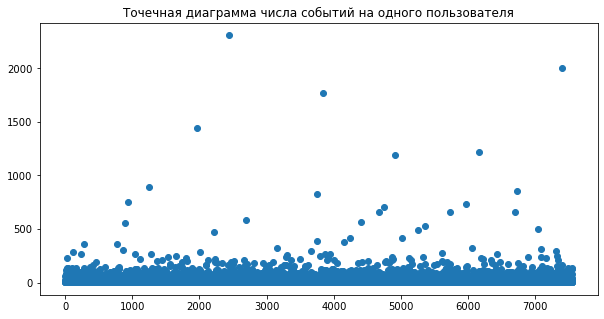

,user_id,event
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221
2641,3337471580007169353,1186
6294,7738058666231999878,888
822,1055544042902443290,854
3801,4713748699910253089,824
6617,8118046800480174342,755


In [18]:
# строим график
plt.figure(figsize=(10,5))
x_values = pd.Series(range(0, len(event_per_user)))

plt.scatter(x_values, event_per_user['event']) 
plt.title('Точечная диаграмма числа событий на одного пользователя')
plt.show()
display(event_per_user.sort_values(by='event', ascending = False)\
                      .head(10))

Большинство точек находится ниже отметки 250 событий и  всего 6 пользователей совершили более 1000 событий. Посчитаем перцентили.

In [19]:
percentiles = np.percentile(event_per_user['event'], [1, 5, 95, 99])
print(f'1 % пользователей совершили: {percentiles[0]} событий\
      \n5 % пользователей совершили: {percentiles[1]} событий\
      \n95 % пользователей совершили: {percentiles[2]} событий\
      \n99 % пользователей совершили: {percentiles[3]} событий')

1 % пользователей совершили: 1.0 событий      
5 % пользователей совершили: 3.0 событий      
95 % пользователей совершили: 89.0 событий      
99 % пользователей совершили: 200.5 событий


In [20]:
event_per_user.query('2< event < 201')['event'].describe()

count    7206.000000
mean       28.990425
std        27.831116
min         3.000000
25%        10.000000
50%        20.000000
75%        38.000000
max       199.000000
Name: event, dtype: float64

Да, 99% пользователей совершает не более 200 действий. В итоге нормальным считаем диапазон от 3 до 200 действий с медианой 20 действий.

Теперь изучим временные рамки.

Text(0, 0.5, 'Количество событий')

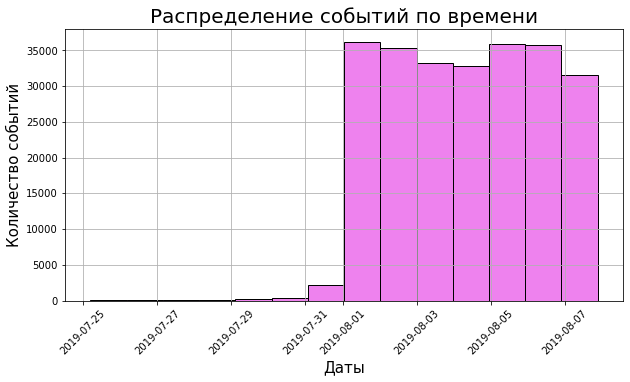

In [21]:
# Строим гистограмму по времени событий в логах
fig = plt.figure(figsize = (10, 5))
logs['date_time'].hist(bins = 14, grid = True, color= 'violet', ec='black')
plt.title('Распределение событий по времени', fontsize=20)
plt.xlabel('Даты',fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Количество событий',fontsize=15)

Хорошо видно,что до 1 августа количество событий незначительно. Полные данные есть только с 1 по 7 августа. Дальше будем работать только с полными данными.

In [22]:
# делаем срез с 1 августа
compleete_logs = logs.query('date >= "2019-08-01"')

Проверим много ли событий и пользователей потеряли, отбросив старые данные. И убедимся что пользователи из всех трёх экспериментальных групп на месте.

In [23]:
event_del = logs['event'].count() - compleete_logs['event'].count()
event_del_persent = event_del/events

users_del = logs['user_id'].nunique() - compleete_logs['user_id'].nunique()
users_del_persent = users_del/users 

print(f"Всего событий в логе: {events}, убрали {event_del} событий или {event_del_persent:.1%}")
print(f"Всего пользоватедей в логе: {users}, убрали {users_del} пользователей или {users_del_persent:.1%}")

print()
print()
print('Всего пользоватедей в каждой группе:')
compleete_group = compleete_logs.groupby('group')\
              .agg({'user_id': ['count', 'nunique']})\
              .reset_index()
compleete_group

Всего событий в логе: 243713, убрали 2826 событий или 1.2%
Всего пользоватедей в логе: 7551, убрали 17 пользователей или 0.2%


Всего пользоватедей в каждой группе:


group user_id        
          count nunique
0   246   79302    2484
1   247   77022    2513
2   248   84563    2537

### Вывод 

В полученных данных хранится информация более чем о 243 тысячах событий, совершенных 7551 пользователем в период с 25 июля по 1 августа 2019 года. В среднем на каждого пользователя пришлось 32 события, но ориентироваться здесь стоит на медиану - 20 событий. Большинство пользователей совершало от 3 до 200 действий.  Построив гистограмму по времени обнаружили, что до 1 августа данные не полные и могут искажать результаты A/B теста. Для дальнейшего анализа была сделана выборка данных за период с 1 по 7 августа, при этом в выборку не вошли 2826 событий(1%) и 17 пользователей(0,2%). Все 3 группы A/A/B теста  на месте и имеют сопоставимые значения.


## Исследование воронки продаж

Для создания воронки нужно знать, сколько людей добрались до каждого этапа вплоть до совершения покупки. 
Для этого:
- Определим, какие события есть в логах, как часто они встречаются. 
- Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. 
- Посчитаем долю пользователей, которые хоть раз совершали событие. Подумаем, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? 

По уже готовой воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Определим, на каком шаге теряется больше всего пользователей и какая доля пользователей доходит от первого события до оплаты?

In [24]:
# считаем количество каждого события
events_count = compleete_logs['event'].value_counts().to_frame()
events_count

,event
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [25]:
#Считаем, сколько пользователей совершали каждое из этих событий
events_per_users = compleete_logs.groupby('event')['user_id']\
                                 .nunique().sort_values(ascending=False)\
                                 .to_frame()\
                                 .reset_index()
events_per_users = events_per_users.rename(columns={'user_id': 'count_users'})        
events_per_users

,event,count_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [26]:
#Посчитаем и добавим долю пользователей, которые хоть раз совершали событие
events_per_users['ratio'] = round(
    events_per_users ['count_users']/ compleete_logs['user_id']\
    .nunique(), 2)\
    .apply(lambda x: f"{x:1.1%}")

events_per_users

,event,count_users,ratio
0,MainScreenAppear,7419,98.0%
1,OffersScreenAppear,4593,61.0%
2,CartScreenAppear,3734,50.0%
3,PaymentScreenSuccessful,3539,47.0%
4,Tutorial,840,11.0%


В нашем логе 5 событий:

- MainScreenAppear - появление главного экрана;
- OffersScreenAppear - появление экрана предложений с товаром;
- CartScreenAppear - экран корзины;
- PaymentScreenSuccessful - экран успешной оплаты заказа.
- Tutorial - появление экрана обучения

Судя по количеству пользователей, совершавших каждое из этих действий, цепочка событий последовательная. Пользователи открывают приложение(появляется главный экран), переходят в каталог, затем переходят в корзину и  после оформления заказа видят экран успешной оплаты. Исключение составляет Tutorial, он не входит в цепочку - его открыло только 11% полбзователей. Вроде бы хороший знак, это может означать, что приложение интуитивно понятно пользователю. Впрочем, смущает количество переходов с главной страницы (98,5% пользователей) на страницу предложений товара (61%). больше трети клиентов теряется уже на этом этапе. Стоит проверить на технические проблемы работу приложения. Возможно долго загружается или не для всех устройств адекватно отображается экран предложений товаров.

Так как Tutorial не входит в цепочку событий, его можно убрать из воронки.

In [27]:
# оставляем 4 события в воронке и запишем в переменную
funnel = events_per_users[events_per_users['event'] != 'Tutorial'].copy()
funnel

,event,count_users,ratio
0,MainScreenAppear,7419,98.0%
1,OffersScreenAppear,4593,61.0%
2,CartScreenAppear,3734,50.0%
3,PaymentScreenSuccessful,3539,47.0%


Теперь по воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [28]:
funnel['convertion_in_step'] = (round(funnel['count_users']/funnel['count_users']\
                               .shift(fill_value = funnel.loc[0,'count_users']),2))\
                               .apply(lambda x: f"{x:1.1%}")
funnel

,event,count_users,ratio,convertion_in_step
0,MainScreenAppear,7419,98.0%,100.0%
1,OffersScreenAppear,4593,61.0%,62.0%
2,CartScreenAppear,3734,50.0%,81.0%
3,PaymentScreenSuccessful,3539,47.0%,95.0%


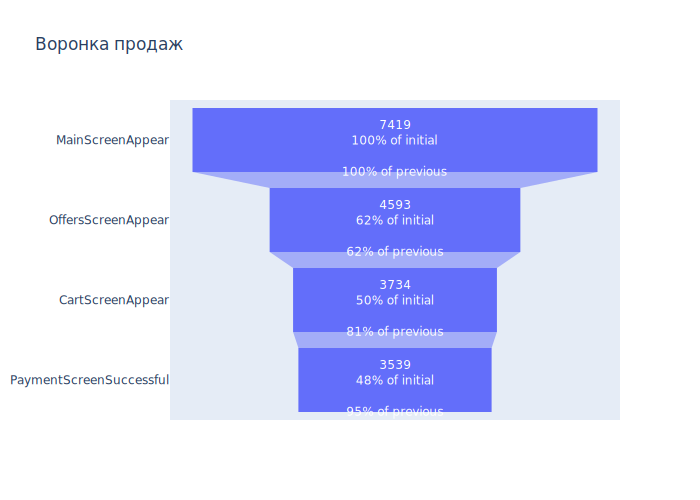

In [29]:
fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = funnel['event'],
    x = funnel['count_users'],
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(
    title={
        'text': "Воронка продаж",
        })
fig.show(renderer="svg")

In [30]:
display('{:.2%} пользователей доходит от первого события до оплаты'.format(funnel['count_users'][3]/funnel['count_users'][0]))

'47.70% пользователей доходит от первого события до оплаты'

### Вывод

В воронке у на сесть цепочка из 4 последовательных событий: от открытия приложения до информационной страницы об успешной оплате. Есть пятое, необязательное,- обучающая страница. Ею воспользовалось только 11% пользователей, что может говорить о хорошо разработанном приложении, которое интуитивно понятно пользователю.

Что касается самой воронки, мы нашли, что большинство пользователей отваливается при переходе на страницу с каталогом товаров- на нее переходит только 62% пользователей. Это может означать технические проблемы. Приложение может долго подгружать каталог с товарами или некорректно отображаться на некоторых устройствах. 

При подсчетах конверсии в шаг нашли, что из каталога в корзину добирается больше 80% пользоваелей. Это хороший показатель, но есть еще куда стремиться. Факторов почему 20% не дошли до корзины множество и эта задача отдельного исследования. А вот информационную страницу об успешности оплаты увидело только 95 процентов пользователей, перешедших в корзину. Не закончили оплату заказа 5% пользователей. Здесь вариантов, почему так случилось, всего 2: либо клиент увидел счет и отказался от покупки, либо есть технические проблемы с оплатой. Стоит поискать техничекие проблемы и здесь.

Через всю воронку от входа в приложение до совершения заказа дошло только 47,7% пользователей. 



## Анализ результатов A/A/B теста

### A/A тест

В датасете имеются 2 контрольные группы для А/А-эксперимента, 246 и 247. Они нужны чтобы проверить корректность всех механизмов и расчётов. 

Критерии успешного A/A-теста:

- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Пересечение групп мы проверили ранее и не нашли. Система аналитики корректно собирает данные т.к. ошибок, пропусков и лишних названий событий в ходе исследовательского анализа мы не обнаружили.  Осталось проверить статистическую значимость в различии ключевых метрик. В нашем случае -это конверсия в покупку "PaymentScreenSuccessful". Соберем группы в сводную таблицу, найдем количество пользователей в каждой группе и напишем функцию для проверки статистики.

In [31]:
#считаем количество пользователей в каждой группе
users= compleete_logs.groupby('group')['user_id']\
                     .nunique()\
                     .to_frame()\
                     .reset_index()
users.loc[3] = ['246+247', 4997]
users = users.set_index(users.columns[0])
users

,user_id
group,
246,2484
247,2513
248,2537
246+247,4997


In [32]:
# собираем сводную табицу по событиям и количеству пользователей его совершивших для каждой группы
# и добавляем колонку с суммой пользователей A/A теста

funnels = compleete_logs.pivot_table(index='event', columns='group',values='user_id',aggfunc='nunique')\
                       .sort_values(246,ascending=False)
funnels['246+247'] = funnels[246] + funnels[247]
funnels.drop(['Tutorial'], inplace=True)
funnels

group,246,247,248,246+247
event,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [33]:
# функция для подсчета Z-критерия
def z_test(value_1, value_2, event, alpha): 
    
    p1_ev = funnels.loc[event, value_1] # срез. отбираем событие и количество значений для первой группы
    p2_ev = funnels.loc[event, value_2] # срез. отбираем событие и количество значений для второй группы
    
    p1_us = users.loc[value_1, 'user_id'] # количество человек в первой группе
    p2_us = users.loc[value_2, 'user_id'] # количество человек во второй группе
    
    p1 = p1_ev / p1_us # пропорция успехов в первой группе
    p2 = p2_ev / p2_us # пропорция успехов во второй группе
    
    difference = p1 - p2 # разница пропорций в датасетах
    
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) # пропорция успехов в комбинированном датасете
    
    # считаем статистику  по общепринятой формуле Z-критерия
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    
    distr = st.norm(0, 1)# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(f'Для групп {value_1} и {value_2} по событию: {event}')
    print(f'p-value: {p_value}')
        
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Применим z_test к нашим группам A/A и посмотрим есть ли статистическое отличие среди долей пользователей, совершивших целевое действие - конверсию в заказ.

- H0 - нет статистически значимой разницы между конверсиями в покупку для первой и второй группы A.
- H1 - Есть статистически значимая разница между конверсиями в покупку для первой и второй группы A.


- уровень значимости alpha = 0.5

In [34]:
event = "PaymentScreenSuccessful"
z_test(246, 247, event, 0.05)


Для групп 246 и 247 по событию: PaymentScreenSuccessful
p-value: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу


Статистических различий между двумя А-группами нет. Можно сделать вывод, что A/A/B тест проведен корректно. Теперь можно вывести воронку продаж с разбивкой по группам.

In [35]:
# делаем срезы данных отдельно по каждой группе
group_246 = compleete_logs[(compleete_logs['group'] == 246) & (compleete_logs['event'] != 'Tutorial')]
group_247 = compleete_logs[(compleete_logs['group'] == 247) & (compleete_logs['event'] != 'Tutorial')]
group_248 = compleete_logs[(compleete_logs['group'] == 248) & (compleete_logs['event'] != 'Tutorial')]

In [36]:
# делаем группировку по каждому срезу
funnel_246 = group_246.groupby('event')['user_id'].nunique()\
                      .sort_values(ascending=False)\
                      .to_frame().reset_index()\
                      .rename(columns={'user_id': 'total_users'})

funnel_247 = group_247.groupby('event')['user_id'].nunique()\
                      .sort_values(ascending=False)\
                      .to_frame().reset_index()\
                      .rename(columns={'user_id': 'total_users'})

funnel_248 = group_248.groupby('event')['user_id'].nunique()\
                      .sort_values(ascending=False)\
                      .to_frame().reset_index()\
                      .rename(columns={'user_id': 'total_users'})

funnel_246

,event,total_users
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


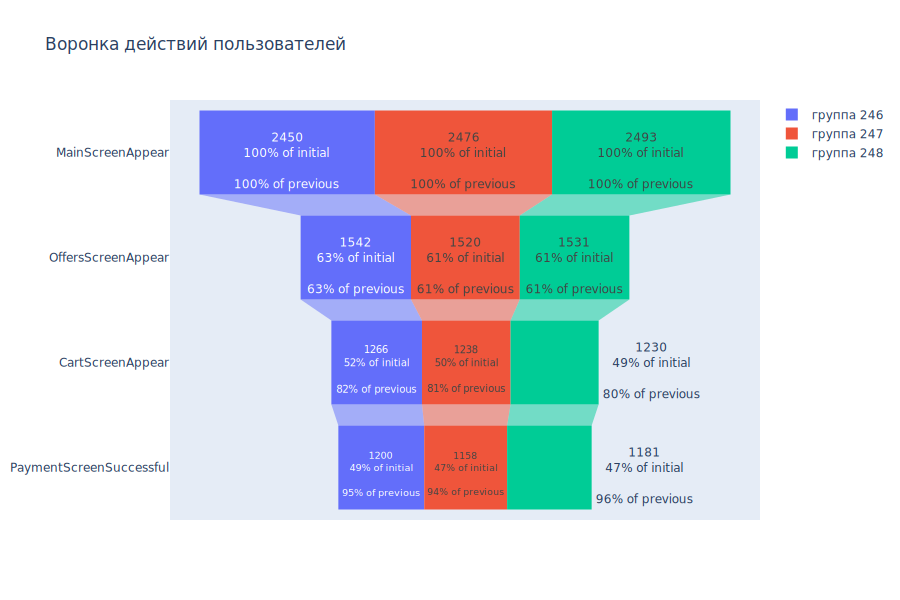

In [45]:
# строим  параллельную воронку для всех трех групп
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'группа 246',
    y = funnel_246['event'],
    x = funnel_246['total_users'],
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = 'группа 247',
    y = funnel_247['event'],
    x = funnel_247['total_users'],
    textinfo = "value+percent initial+percent previous"))

fig.add_trace(go.Funnel(
    name = 'группа 248',
    y = funnel_248['event'],
    x = funnel_248['total_users'],
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(
            height=600, width=900,
        title={'text': "Воронка действий пользователей",})
fig.show(renderer="svg")

На каждом этапе воронки группы ведут себя очень похоже. Процентное соотношение переходов с шага на шаг отличается незначительно. Это предварительно дает понять, что изменение шрифта в приложении, скорее всего, не повлияло на поведение пользователей в приложении.

Самым популярным событием является открытие главного экрана. В разрезе по группам получили следующее соотношение:
- Группа 246: 2450 пользователей(37,9% от всех)
- Группа 247: 2476 пользователей(38,7% от всех)
- Группа 248: 2493 пользователей(38,7% от всех)

Но есть ли статистическая разница? На первый взгяд - нет. Применим z-критерий ко всем группам попарно: 
- контрольная 246 и экспериментальная 248
- контрольная 247 и экспериментальная 248
- суммарная группа 246 + 247 и экспериментальная 248

и для каждой пары групп и по каждому событию посмотрим есть ли статистические различия.

### Анализ результатов A/A/B теста

Поочередно вызываем функцию для каждой пары групп.

- H0 - нет статистически значимой разницы между одним и тем же действием, совершенным пользователями группы 1 и группы 2.
- H1 - есть статистически значимая разница между одним и тем же действием, совершенным пользователями группы 1 и группы 2.
- уровень значимости alpha = 0.05

In [46]:
# сравниваем группы 246 и 247 (до этого мы уже считали отдельно "PaymentScreenSuccessful", но повторимся)
for event in funnels.index:
    z_test(246, 247, event, 0.05)
    print()

Для групп 246 и 247 по событию: MainScreenAppear
p-value: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 247 по событию: OffersScreenAppear
p-value: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 247 по событию: CartScreenAppear
p-value: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 247 по событию: PaymentScreenSuccessful
p-value: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу



In [47]:
# сравниваем группы 246 и 248
for event in funnels.index:
    z_test(246, 248, event, 0.05)
    print()

Для групп 246 и 248 по событию: MainScreenAppear
p-value: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 248 по событию: OffersScreenAppear
p-value: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 248 по событию: CartScreenAppear
p-value: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 248 по событию: PaymentScreenSuccessful
p-value: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу



In [48]:
# сравниваем группы 247 и 248
for event in funnels.index:
    z_test(247, 248, event, 0.05)
    print()

Для групп 247 и 248 по событию: MainScreenAppear
p-value: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу

Для групп 247 и 248 по событию: OffersScreenAppear
p-value: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу

Для групп 247 и 248 по событию: CartScreenAppear
p-value: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу

Для групп 247 и 248 по событию: PaymentScreenSuccessful
p-value: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу



In [49]:
# сравниваем группы 246+247 и 248
for event in funnels.index:
    z_test('246+247', 248, event, 0.05)
    print()

Для групп 246+247 и 248 по событию: MainScreenAppear
p-value: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу

Для групп 246+247 и 248 по событию: OffersScreenAppear
p-value: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу

Для групп 246+247 и 248 по событию: CartScreenAppear
p-value: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу

Для групп 246+247 и 248 по событию: PaymentScreenSuccessful
p-value: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу



Как и предполагалось, статистических различий нет. Уровень p-value почти на всех тестах значительно выше  значения alpha = 0,05. Самое минимальное отличие нашли для групп 246 и 248 по событию CartScreenAppear, p-value составил 0.08.

Попробуем увеличить alpha и примем равному 0,1. Повторим тесты. 

In [50]:
# сравниваем группы 246 и 247
for event in funnels.index:
    z_test(246, 247, event, 0.1)
    print()

Для групп 246 и 247 по событию: MainScreenAppear
p-value: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 247 по событию: OffersScreenAppear
p-value: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 247 по событию: CartScreenAppear
p-value: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 247 по событию: PaymentScreenSuccessful
p-value: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу



In [51]:
# сравниваем группы 246 и 248
for event in funnels.index:
    z_test(246, 248, event, 0.1)
    print()

Для групп 246 и 248 по событию: MainScreenAppear
p-value: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 248 по событию: OffersScreenAppear
p-value: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу

Для групп 246 и 248 по событию: CartScreenAppear
p-value: 0.07842923237520116
Отвергаем нулевую гипотезу

Для групп 246 и 248 по событию: PaymentScreenSuccessful
p-value: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу



In [52]:
# сравниваем группы 247 и 248
for event in funnels.index:
    z_test(247, 248, event, 0.1)
    print()

Для групп 247 и 248 по событию: MainScreenAppear
p-value: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу

Для групп 247 и 248 по событию: OffersScreenAppear
p-value: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу

Для групп 247 и 248 по событию: CartScreenAppear
p-value: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу

Для групп 247 и 248 по событию: PaymentScreenSuccessful
p-value: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу



In [53]:
# сравниваем группы 246+247 и 248
for event in funnels.index:
    z_test('246+247', 248, event, 0.1)
    print()

Для групп 246+247 и 248 по событию: MainScreenAppear
p-value: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу

Для групп 246+247 и 248 по событию: OffersScreenAppear
p-value: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу

Для групп 246+247 и 248 по событию: CartScreenAppear
p-value: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу

Для групп 246+247 и 248 по событию: PaymentScreenSuccessful
p-value: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу



### Вывод

Мы провели 16 тестов для трех групп A/A/B и одной сводной A/A по 4 уровням воронки, используя z-критерий. Расчеты проводили с уровнем значимости alpha = 0,05 и затем пересчитали с уровнем значимости alpha = 0,1. Во  всех случаях, при alpha = 0,05,  не удалось обнаружить статистически значимого различия между группами. При alpha = 0,1 в 1 из 16 тестов нашлось статистически значимое отличие по событию CartScreenAppear для групп 246 и 248, p-value: 0,0784. Учитывая, что для других пар сравнения 246 vs 247, 246+247 vs 248 и 247 vs 248 таких различий не нашлось и значения p-value во всех этих случаях больше 0,1, стоит оставить уровень значимости alpha = 0,05, так как в этом случае вероятность ошибки первого рода меньше.

Делаем  вывод, что изменение шрифтов не влияет на поведение пользователей.

## Общий вывод

Для исследования результатов A/A/B-эксперимента был собран лог событий, совершенных пользователями этих трех групп в приложении. В полученных данных хранится информация более чем о 243 тысячах событий, совершенных 7551 пользователем в период с 25 июля по 1 августа 2019 года. Построив гистограмму по времени обнаружили, что до 1 августа данные не полные и могут искажать результаты A/B теста. Для дальнейшего анализа была сделана выборка данных за период с 1 по 7 августа, при этом в выборку не вошли 2826 событий(1%) и 17 пользователей(0,2%). Все 3 группы A/A/B теста остались на месте и имеют сопоставимые значения.

В построенной воронке событий мы нашли, что большинство пользователей отваливается при переходе на страницу с каталогом товаров- на нее переходит только 62% пользователей. Это может означать технические проблемы. Приложение может долго подгружать каталог с товарами или некорректно отображаться на некоторых устройствах.

При подсчетах конверсии в шаг нашли, что из каталога в корзину добирается больше 80% пользоваелей. Это хороший показатель, но есть еще куда стремиться. Факторов почему 20% не дошли до корзины множество и эта задача отдельного исследования. А вот информационную страницу об успешности оплаты увидело только 95 процентов пользователей, перешедших в корзину. Не закончили оплату заказа 5% пользователей. Здесь вариантов, почему так случилось, всего 2: либо клиент увидел счет и отказался от покупки, либо есть технические проблемы с оплатой. Беспокойство также вызывает и то, что первую -главную страницу приложения увидело только 98,5% пользователей. Стоит поискать техничекие проблемы и по этим направлениям. 
Через всю воронку от входа в приложение до совершения заказа дошло только 47,7% пользователей.

По итогам исследования событий можно сказать,что система аналитики корректно собирает данные т.к. ошибок, пропусков и лишних названий событий в ходе исследовательского анализа мы не обнаружили. 

По результатам исследования A/A/B-эксперимента мы провели 16 тестов для трех групп A/A/B и одной сводной A/A по 4 уровням воронки, при заданном alpha = 0,05. Ни в одном случае не удалось обнаружить статистически значимого различия между группами. Из чего можно сделать вывод, что изменение шрифтов в приложении никак не сказалось на поведении пользователей и, при желании, шрифты можно поменять, но дополнительной выгоды это не принесет, впрочем, и не ухудшит ситуацию.